# WOfS the hell

### List of wetland edits

push to github every time you change one of these!!!!
- wofs bit flags - include low angle wofs
- check for 90% coverage of shape, not just load
- if no data, redo load with no 90% thing, then monthly aggregate before checking for coverage
-  tighten graph and increase text size


- wofs - plot to see what the actual values are in between 
- wofs - fill gaps with ndwi
- wofs - plot against surface reflectance

- use bens awesome stats code to gap fill?

- rolling average for inference?
        

### import modules


In [166]:
import datacube
import datetime
import fiona
import geopandas as gpd
import numpy as np
import pandas as pd
import rasterio.mask
import rasterio.features
from shapely import geometry
import seaborn as sns
import sys
import xarray as xr

from datetime import datetime, timedelta
from matplotlib.patches import Rectangle

import matplotlib.dates as mdates
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt

from datacube.storage import masking
from datacube.utils import geometry
from digitalearthau.utils import wofs_fuser

sys.path.append('/g/data/r78/rjd547/jupyter_notebooks/dea-notebooks/10_Scripts')
import DEADataHandling, DEAPlotting, TasseledCapTools

dc = datacube.Datacube(app='tci and wofs')

global Output_dir
Output_dir = '/g/data/r78/rjd547/Ramsar_Wetlands/Ramsar_Outputs_2/'

### Set up polygon

In [163]:
def get_RAMSAR_polyName(shapefile):
    ''' function designed specifically for the RAMSAR wetlands australia shapefile. Takes the shapefile and extracts
    the ramsar name, wetland name and objectID from the ESRI shapefile format and turns it into a useful string for our output.
    :Inputs: shapefile with RAMSAR_NAM, WETLAND_NA, and OBJECTID as properties. 
    Author: Bex Dunn Last Edited: March 2019'''
    # get the ramsar name from the shapes 
    RAMSAR_NAME = '_'.join(shapefile['properties']['RAMSAR_NAM'].split(' '))
    WETLAND_NAME = '_'.join(shapefile['properties']['WETLAND_NA'].split(' '))
    STATE = '_'.join(shapefile['properties']['STATE'].split(' ')) 
    ID = shapefile['id']
    polyName = f'{RAMSAR_NAME}-{WETLAND_NAME}-{STATE}-{ID}'
    print(f'processing polygon {polyName}')
    return(polyName)

In [164]:
#change the path here if you want a different polygon
#poly_path = '/g/data/r78/rjd547/groundwater_activities/Burdekin/Burdekin_shapefiles/reeves_lake_for_demo.shp'
poly_path = '/g/data/r78/rjd547/Ramsar_Wetlands/shapefiles/ExplodedRAMSAR.shp'

In [3]:
#open the polygon and manually select your favourite polygon the lazy way
with fiona.open(poly_path) as shapes:
        crs = geometry.CRS(shapes.crs_wkt)
        #first_geometry = next(iter(shapes))['geometry']
        #geom = geometry.Geometry(first_geometry, crs=crs)
        for feature in shapes:
            #print(feature['properties']['WETLAND_NA'])
            if feature['properties']['WETLAND_NA']=='Lake Charm':
                lake_charm =feature
                lake_charm_geometry = lake_charm['geometry']
                geom = geometry.Geometry(lake_charm_geometry, crs=crs)

### Set up query

In [74]:
query = {'geopolygon': geom,
         #'time': ('2016-01-01', '2018-06-30')
         #'time': ('2007-01-01', '2007-06-30')
         #'time': ('2018-01-01', '2019-01-01')
         }

### Load cloudmasked data

### mask the data with our original polygon to remove extra data 

In [75]:
landsat_masked_prop = 0.90
ls578 = DEADataHandling.load_clearlandsat(dc=dc, query=query, product='nbart',masked_prop=landsat_masked_prop)

Loading ls5
    Loading 303 filtered ls5 timesteps
Loading ls7
    Ignoring SLC-off observations for ls7
    Loading 42 filtered ls7 timesteps
Loading ls8
    Loading 73 filtered ls8 timesteps
Combining and sorting ls5, ls7, ls8 data
    Replacing invalid -999 values with NaN (data will be coerced to float64)


### let's have a look at our data looks in false color

In [105]:
#DEAPlotting.rgb(ls578, bands=['swir1','nir','green'], col='time')

In [77]:
data = ls578

mask = rasterio.features.geometry_mask([geom.to_crs(data.geobox.crs)for geoms in [geom]],
                                           out_shape=data.geobox.shape, 
                                           transform=data.geobox.affine,
                                           all_touched=False,
                                           invert=False)

In [78]:
#for some reason xarray is not playing nicely with our old masking function
mask_xr = xr.DataArray(mask, dims = ('y','x'))
ls578_ds = data.where(mask_xr==False)

In [79]:
#transform the nbart into tci
tci = TasseledCapTools.thresholded_tasseled_cap(ls578_ds,wetness_threshold=-350, drop=True , drop_tc_bands=True)

In [80]:
#select only finite values (over threshold values)
tcw = xr.ufuncs.isfinite(tci.wetness_thresholded)

In [81]:
# #reapply the polygon mask
tcw = tcw.where(mask_xr==False)

# trying to fix wofs flagging

In [82]:
### try using dc load instead of 'like'

In [83]:
#load wofs
#wofls = dc.load(product = 'wofs_albers', like=ls578_ds, fuse_func=wofs_fuser)
wofls = dc.load(product = 'wofs_albers',fuse_func=wofs_fuser, **query)

#first, match tcw and wofs

In [84]:
wofls = wofls.where(wofls.time ==tci.time)

In [85]:
#reapply the polygon mask
#for some reason xarray is not playing nicely with our old masking function
mask_xr = xr.DataArray(mask, dims = ('y','x'))
wofls = wofls.where(mask_xr==False)

In [86]:
#wofls.water.plot(col='time', col_wrap=4)

In [106]:
wet_wofs = wofls.where(wofls.water==128)
#wet_wofs.water.plot(col='time', col_wrap=4)

In [107]:
shadow_wofs = wofls.where(wofls.water== 136) #use bit values for wet (128) and terrain/low-angle (8)
#shadow_wofs.water.plot(col='time', col_wrap=4)

### load in fractional cover data

In [89]:
#load the data according to our query
#choose a mask proportion to look for a clear timestep
fc_ds = DEADataHandling.load_clearlandsat(dc, query,product='fc',masked_prop=0.90)

Loading ls5
    Loading 303 filtered ls5 timesteps
Loading ls7
    Ignoring SLC-off observations for ls7
    Loading 42 filtered ls7 timesteps
Loading ls8
    Loading 73 filtered ls8 timesteps
Combining and sorting ls5, ls7, ls8 data
    Replacing invalid -999 values with NaN (data will be coerced to float64)


### mask FC with polygon

In [90]:
fc_ds = fc_ds.where(mask_xr==False)

### mask FC with wetness

In [131]:
fc_ds_noTCW=fc_ds.where(tcw==False)
#match timesteps
fc_ds_noTCW= fc_ds_noTCW.where(fc_ds_noTCW.time==tcw.time)

### Calculate number of pixels in area of interest

In [111]:
#number of pixels in area of interest
pixels = (mask_xr==0).sum(dim=['x','y'])

In [112]:
mask_xr==0
mask_xr.count(dim=['x','y'])

<xarray.DataArray ()>
array(28380)

In [113]:
#count number of wofs pixels
wofs_pixels = wet_wofs.water.count(dim=['x','y'])
shadow_wofs_pixels = shadow_wofs.water.count(dim=['x','y'])

In [114]:
#count percentage of area of wofs
wofs_area_percent = ((wofs_pixels+shadow_wofs_pixels)/pixels)*100

In [134]:
#count number of tcw pixels
tcw_pixel_count = tcw.sum(dim=['x','y'])

#calculate percentage area wet
tcw_area_percent = (tcw_pixel_count/pixels)*100

#calculate wet not wofs
tcw_less_wofs = tcw_area_percent-wofs_area_percent

### Calculate the dominant fraction for each pixel in Fractional Cover

In [135]:
#drop data percentage and Unmixing Error
fc_tester = fc_ds_noTCW.drop(['data_perc','UE'])

#following robbi's advice, cast the dataset to a dataarray
maxFC = fc_tester.to_array(dim='variable', name='maxFC')

#turn FC array into integer only as nanargmax doesn't seem to handle floats the way we want it to
FC_int = maxFC.astype('int8')

#use numpy.nanargmax to get the index of the maximum value along the variable dimension
#BSPVNPV=np.nanargmax(FC_int, axis=0)
BSPVNPV=FC_int.argmax(dim='variable')

FC_mask=xr.ufuncs.isfinite(maxFC).all(dim='variable')

# #re-mask with nans to remove no-data
BSPVNPV=BSPVNPV.where(FC_mask)

In [136]:
FC_dominant = xr.Dataset({
    'BS': (BSPVNPV==0).where(FC_mask),
    'PV': (BSPVNPV==1).where(FC_mask),
    'NPV': (BSPVNPV==2).where(FC_mask),
})

In [137]:
FC_count = FC_dominant.sum(dim=['x','y'])

In [138]:
FC_count

<xarray.Dataset>
Dimensions:  (time: 418)
Coordinates:
  * time     (time) datetime64[ns] 1987-07-12T23:40:32.500000 ... 2019-03-15T00:15:00
Data variables:
    BS       (time) float64 100.0 40.0 24.0 33.0 ... 293.0 269.0 349.0 343.0
    PV       (time) float64 910.0 1.038e+03 315.0 182.0 ... 459.0 466.0 531.0
    NPV      (time) float64 734.0 708.0 1.442e+03 ... 1.104e+03 1.03e+03 935.0

In [139]:
#Fractional cover pixel count method
#Get number of FC pixels, divide by total number of pixels per polygon

Bare_soil_percent=(FC_count.BS/pixels)*100

Photosynthetic_veg_percent=(FC_count.PV/pixels)*100

NonPhotosynthetic_veg_percent=(FC_count.NPV/pixels)*100

NoData = 100 - wofs_area_percent- tcw_less_wofs - Photosynthetic_veg_percent - NonPhotosynthetic_veg_percent - Bare_soil_percent

In [155]:
#match timesteps for all variables

In [150]:
wofs_area_percent=wofs_area_percent.where(wofs_area_percent.time==Bare_soil_percent.time)
Bare_soil_percent=Bare_soil_percent.where(Bare_soil_percent.time==wofs_area_percent.time)
Photosynthetic_veg_percent=Photosynthetic_veg_percent.where(Photosynthetic_veg_percent.time==wofs_area_percent.time)
NonPhotosynthetic_veg_percent=NonPhotosynthetic_veg_percent.where(NonPhotosynthetic_veg_percent.time==wofs_area_percent.time)

In [157]:
polyName = get_RAMSAR_polyName(lake_charm)

processing polygon Kerang_Wetlands-Lake_Charm-VIC-48


<Figure size 432x288 with 0 Axes>

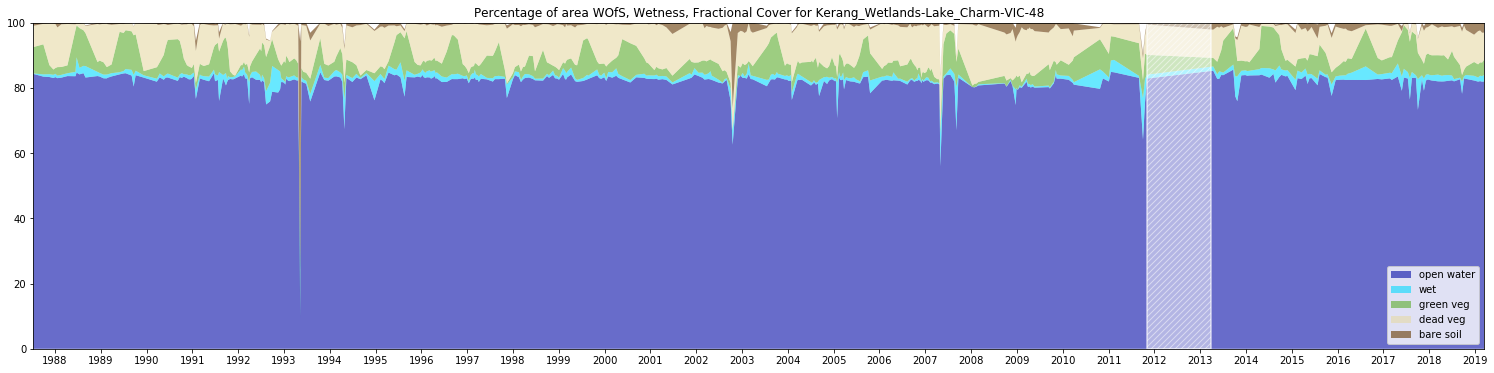

plot created for Kerang_Wetlands-Lake_Charm-VIC-48


In [170]:
#set up color palette
        pal = [sns.xkcd_rgb["cobalt blue"],
               sns.xkcd_rgb["neon blue"],
               sns.xkcd_rgb["grass"],
               sns.xkcd_rgb["beige"],
               sns.xkcd_rgb["brown"]]       
        #try and figure out what the error is on one of the plots
        #make a stacked area plot
        plt.clf()
        plt.figure(figsize = (26,6))
        plt.stackplot(wofs_area_percent.time.values, 
                      wofs_area_percent, 
                      tcw_less_wofs, 
                      Photosynthetic_veg_percent, 
                      NonPhotosynthetic_veg_percent,
                      Bare_soil_percent,
                     labels=['open water',
                      'wet',
                      'green veg',
                      'dead veg',
                      'bare soil',
                     ], colors=pal, alpha = 0.6)


        plt.title(f'Percentage of area WOfS, Wetness, Fractional Cover for {polyName}')


        #set date ticks every year

        years = mdates.YearLocator(1)
        yearsFmt = mdates.DateFormatter('%Y')

        #set axis limits to the min and max
        plt.axis(xmin = wofs_area_percent.time[0].data, xmax = wofs_area_percent.time[-1].data, ymin = 0, ymax = 100)
        ax = plt.gca()
        ax.xaxis.set_major_locator(years)
        ax.xaxis.set_major_formatter(yearsFmt)
        #add a legend and a tight plot box
        plt.legend(loc='lower right')
        #plt.tight_layout()

        #create rectangle borders for no-data times (SLC-off only)
        LS5_8_gap_start = datetime(2011,11,1)
        LS5_8_gap_end = datetime(2013,4,1)

        # convert to matplotlib date representation
        gap_start = mdates.date2num(LS5_8_gap_start)
        gap_end = mdates.date2num(LS5_8_gap_end)
        gap = gap_end - gap_start

        #set up rectangle
        slc_rectangle= Rectangle((gap_start,0), gap, 100,alpha = 0.5, facecolor=sns.xkcd_rgb['white'],
                     edgecolor=sns.xkcd_rgb['white'], hatch="////",linewidth=2)
        ax.add_patch(slc_rectangle)


        #save the figure
        plt.savefig(f'{Output_dir}{polyName}.png')#, transparent=True)
        plt.show()
        print(f'plot created for {polyName}')
